In [185]:
import pandas as pd
import numpy as np


path = '/Users/jonzimmerman/Desktop/Data Projects/Amtrak/data/'
amtrak_df = pd.read_csv(path + 'amtrak_prepped_df.csv')
amtrak_df.shape

(33432, 14)

In [186]:
amtrak_df.head(2)

,Year,Month,Rides,address,state,station_name,abbrev,lat,lon,num_routes,active_routes,active_rides,parent_route,business_line
0,2016,1,1486.44,"18 E Bel Air Ave Aberdeen, MD 21001-3701",MD,"Aberdeen, MD",ABE,39.509437,-76.163827,1,['northeast_regional_route'],[21767995.0],Northeast Regional,Northeast Corridor
1,2016,2,2229.66,"18 E Bel Air Ave Aberdeen, MD 21001-3701",MD,"Aberdeen, MD",ABE,39.509437,-76.163827,1,['northeast_regional_route'],[21767995.0],Northeast Regional,Northeast Corridor


In [187]:
#--- Combine Year and Month
amtrak_df['year_month'] = pd.to_datetime(amtrak_df[['Year', 'Month']].assign(day=1))
amtrak_df['year_month'] = amtrak_df['year_month'].dt.strftime('%Y-%m-%d')

### Step 1: Check for any missing ride #s 

In [188]:
missing = pd.DataFrame(amtrak_df.groupby('station_name')['Rides'].apply(lambda x: x.isna().sum())).reset_index()
missing[missing['Rides']>0]

,station_name,Rides
11,"Arcadia, MO",12
23,"Bellingham, WA",24
108,"Fairfield-Vacaville, CA",24
198,"Lodi, CA",12
208,"Marks, MS",24
230,"Mount Vernon, WA",12
273,"Plattsburhg, NY",24
295,"Roanoke, VA",24
342,"State Street-New Haven, CT",24
343,"Stockton-Downtown, CA",12


### List out info that will be used in imputation process for each station

In [189]:
missing_list = missing[missing['Rides']>0]['station_name'].unique().tolist()
more_info_about_missing_rides = amtrak_df[amtrak_df['station_name'].isin(missing_list)]
missing_inputs = more_info_about_missing_rides[['station_name','abbrev','lat','lon']].drop_duplicates()
missing_inputs

,station_name,abbrev,lat,lon
924,"Arcadia, MO",ACD,37.649536,-90.671728
1932,"Bellingham, WA",BEL,48.720417,-122.511263
9156,"Fairfield-Vacaville, CA",FFV,38.285447,-121.967975
16632,"Lodi, CA",LOD,38.133181,-121.271741
17472,"Marks, MS",MKS,34.258176,-90.272366
19320,"Mount Vernon, WA",MVW,48.417792,-122.334634
22764,"Plattsburhg, NY",PLB,44.696703,-73.446430
24276,"Roanoke, VA",RNK,37.273114,-79.943461
28056,"State Street-New Haven, CT",STS,41.295149,-72.937242
28140,"Stockton-Downtown, CA",SKT,37.955839,-121.278763


## Which years are missing?

In [253]:
stn_code = "SKT"
missing_years = pd.DataFrame(more_info_about_missing_rides[more_info_about_missing_rides['abbrev']==stn_code].groupby('Year')['Rides'].sum()).reset_index()
years_list = missing_years[missing_years['Rides']==0]['Year'].unique().tolist()
years_list

[2021]

### Impute rides based on factor of closest station

In [254]:
# Given latitude and longitude
given_lat = missing_inputs[missing_inputs['abbrev']==stn_code]['lat'].values[0]
given_lon = missing_inputs[missing_inputs['abbrev']==stn_code]['lon'].values[0]

# Function to calculate the Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Filter out same stations
amtrak_df_test = amtrak_df[amtrak_df['abbrev']!=stn_code]

#Remove stations in missing list so we dont use them
amtrak_df_test = amtrak_df_test[~amtrak_df_test['abbrev'].isin(missing_inputs['abbrev'].unique().tolist())]

# Apply the function to calculate distance for each row
amtrak_df_test['Distance'] = amtrak_df_test.apply(lambda row: haversine(given_lat, given_lon, row['lat'], row['lon']), axis=1)

# Find the row with the minimum distance
closest_row = amtrak_df_test.loc[amtrak_df_test['Distance'].idxmin()]


if closest_row['station_name'] in missing_list:
    print(f"{closest_row['station_name']} ({closest_row['abbrev']}) is in the stations with missing rides list.")
else:
    print('Closest station is: ', closest_row['station_name'])
    print('Station Code: ', closest_row['abbrev'])

Closest station is:  Modesto, CA
Station Code:  MOD


In [255]:
# Find factor difference between means of 2 stations - impute missing year adjusted by factor

imp_stn_code = closest_row['abbrev']
org_stn_code = stn_code

denominator = amtrak_df[amtrak_df['abbrev']==imp_stn_code]['Rides'].mean()
numerator = amtrak_df[amtrak_df['abbrev']==org_stn_code]['Rides'].mean()

factor = numerator/denominator
print(f'Avg Rides per month for {imp_stn_code}: ', denominator)
print(f'Avg Rides per month for {org_stn_code}: ', numerator)
print('Factor to adjust imputations: ', factor)

Avg Rides per month for MOD:  7854.761904761905
Avg Rides per month for SKT:  1709.9305555555554
Factor to adjust imputations:  0.21769349297767


In [256]:
imputed_values = amtrak_df[amtrak_df['abbrev']==imp_stn_code][['Year','Month','Rides']]
imputed_values = imputed_values[imputed_values['Year'].isin(years_list)]
imputed_values['Rides'] = imputed_values['Rides']*factor
imputed_values['abbrev'] = org_stn_code
imputed_values

,Year,Month,Rides,abbrev
19044,2021,1,449.319370,SKT
19045,2021,2,673.979054,SKT
19046,2021,3,786.308897,SKT
19047,2021,4,1010.968581,SKT
19048,2021,5,1235.628266,SKT
19049,2021,6,1235.628266,SKT
19050,2021,7,1347.958109,SKT
19051,2021,8,1123.298424,SKT
19052,2021,9,786.308897,SKT
19053,2021,10,673.979054,SKT


In [257]:
# Merge the dataframes on the common columns
amtrak_df = pd.merge(amtrak_df, imputed_values, on=['Year', 'Month', 'abbrev'], how='left', suffixes=('', '_imputed'))

# Replace missing values in 'value' column with values from 'value_impute'
amtrak_df['Rides'] = amtrak_df['Rides'].combine_first(amtrak_df['Rides_imputed'])

# Drop the 'value_impute' column if no longer needed
amtrak_df = amtrak_df.drop(columns=['Rides_imputed'])

In [258]:
# Check missing again
missing = pd.DataFrame(amtrak_df.groupby('station_name')['Rides'].apply(lambda x: x.isna().sum())).reset_index()
missing[missing['Rides']>0]

,station_name,Rides


### Save imputed version of data

In [2]:
#amtrak_df.to_csv('amtrak_df_v2.csv',index=False)

### Reread into notebook

In [72]:
import pandas as pd
import numpy as np
path = '/Users/jonzimmerman/Desktop/Data Projects/Amtrak/data/'
amtrak_df = pd.read_csv(path + 'amtrak_df_v2.csv')
amtrak_df.head(2)

,Year,Month,Rides,address,state,station_name,abbrev,lat,lon,num_routes,active_routes,active_rides,parent_route,business_line,year_month
0,2016,1,1486.44,"18 E Bel Air Ave Aberdeen, MD 21001-3701",MD,"Aberdeen, MD",ABE,39.509437,-76.163827,1,['northeast_regional_route'],[21767995.0],Northeast Regional,Northeast Corridor,2016-01-01
1,2016,2,2229.66,"18 E Bel Air Ave Aberdeen, MD 21001-3701",MD,"Aberdeen, MD",ABE,39.509437,-76.163827,1,['northeast_regional_route'],[21767995.0],Northeast Regional,Northeast Corridor,2016-02-01


In [73]:
amtrak_df['parent_route'] = np.where(amtrak_df['parent_route'].isna(), "Other", amtrak_df['parent_route'])
amtrak_df['business_line'] = np.where(amtrak_df['business_line'].isna(), "Other", amtrak_df['business_line'])

In [74]:
amtrak_df['business_line'].value_counts()

business_line
Long Distance         19656
State Supported        7392
Other                  4284
Northeast Corridor     2100
Name: count, dtype: int64

### Create case weights

In [75]:
# Get the most recent time in the dataframe for reference
from datetime import datetime

max_month = amtrak_df['year_month'].max()
date_format = '%Y-%m-%d'
date_object = datetime.strptime(max_month, date_format)
date_object

#Calculate the difference in months between each date in the 'Time' column and the most recent date
months_diff = (date_object.year - amtrak_df['Year']) * 12 + date_object.month - amtrak_df['Month']

# More recent months get higher weights, e.g., weight decreases with the number of months passed
amtrak_df['weight'] = 10 - months_diff
amtrak_df['weight'] = amtrak_df['weight'].clip(lower=1)  # Ensure weights do not go below 1
amtrak_df.head(2)

,Year,Month,Rides,address,state,station_name,abbrev,lat,lon,num_routes,active_routes,active_rides,parent_route,business_line,year_month,weight
0,2016,1,1486.44,"18 E Bel Air Ave Aberdeen, MD 21001-3701",MD,"Aberdeen, MD",ABE,39.509437,-76.163827,1,['northeast_regional_route'],[21767995.0],Northeast Regional,Northeast Corridor,2016-01-01,1
1,2016,2,2229.66,"18 E Bel Air Ave Aberdeen, MD 21001-3701",MD,"Aberdeen, MD",ABE,39.509437,-76.163827,1,['northeast_regional_route'],[21767995.0],Northeast Regional,Northeast Corridor,2016-02-01,1


### Step 2: Split into training and calibration datasets

In [76]:
cutoff_date = '2021-07-01'

train_df = amtrak_df[amtrak_df['year_month']<cutoff_date]
calib_df = amtrak_df[amtrak_df['year_month']>=cutoff_date]

#Check dimensions
print("TRN set dimensions: ", train_df.shape)
print("CLB set dimensions: ", calib_df.shape)
print('Training set is ', round(train_df.shape[0]/ (train_df.shape[0]+calib_df.shape[0]),2)*100, '% of full data')

TRN set dimensions:  (26268, 16)
CLB set dimensions:  (7164, 16)
Training set is  79.0 % of full data


### Step 3: Fit model to training data

In [77]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

%time

# Ensure 'year_month' is in datetime format
train_df['year_month'] = pd.to_datetime(train_df['year_month'])

# Convert dates to numeric format
train_df['date_num'] = (train_df['year_month'] - train_df['year_month'].min()).dt.days

# Add seasonal component (e.g., month of the year)
train_df['month'] = train_df['year_month'].dt.month

# Define the formula for Poisson regression with seasonal component
formula = 'Rides ~ date_num + C(month)'

# Group the training data by the grouping variable
grouped = train_df.groupby('station_name')

# Prepare a dictionary to store models and future predictions
models = {}
future_predictions = {}

# Forecasting horizon
forecast_horizon = 18

# Fit Poisson regression models for each group and make future predictions
for group_name, group_data in grouped:
    # Fit the model
    model = smf.poisson(formula=formula, data=group_data).fit(disp=False)

    models[group_name] = model

    # Create future data points for prediction
    last_date_num = group_data['date_num'].max()
    
    future_dates = pd.date_range(start=group_data['year_month'].max() + pd.DateOffset(months=1), periods=forecast_horizon, freq='M')
    future_date_num = (future_dates - train_df['year_month'].min()).days
    
    # Add future months to the future data
    future_month = future_dates.month
    
    future_data = pd.DataFrame({
        'date_num': future_date_num,
        'month': future_month
    })

    # Make predictions for the future data points
    future_predictions[group_name] = model.predict(future_data)
    
    
    # Calculate diagnostic statistics manually
    y_true = group_data['Rides']
    y_pred = model.predict(group_data)
    
    # Deviance residuals
    deviance_residuals = np.sign(y_true - y_pred) * np.sqrt(2 * (y_true * np.log(y_true / y_pred) - (y_true - y_pred)))
    pearson_residuals = (y_true - y_pred) / np.sqrt(y_pred)

    influence = model.get_influence()
    leverage = influence.hat_matrix_diag
    cooks_distance = influence.cooks_distance[0]

    # Store diagnostic statistics
    diagnostics = {
        'station_name': group_name,
        'mean_deviance_residuals': np.mean(deviance_residuals),
        'std_deviance_residuals': np.std(deviance_residuals),
        'mean_pearson_residuals': np.mean(pearson_residuals),
        'std_pearson_residuals': np.std(pearson_residuals),
        'mean_leverage': np.mean(leverage),
        'std_leverage': np.std(leverage),
        'mean_cooks_distance': np.mean(cooks_distance),
        'std_cooks_distance': np.std(cooks_distance)
    }
    diagnostic_stats.append(diagnostics)

print('Done.')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
Done.


### Step 3a: Plot some predictions

In [80]:
start_date = '2021-07-01'
end_date = '2022-12-01'
future_dates = pd.date_range(start=start_date, end=end_date, freq='MS')

future_dates_list = future_dates.strftime('%Y-%m-%d').tolist()

# Arrange the predictions in the same structure as the original data
dict_df = pd.DataFrame(future_predictions)
preds = pd.melt(dict_df, var_name='station_name', value_name='Rides')


# Number of stations
num_stns = len(preds['station_name'].unique())

# Create a DataFrame with the date list repeated for each city
date_series = pd.Series(future_dates_list * num_stns)

# Add the date column to the original DataFrame
preds['year_month'] = date_series.values

preds.head(3)


,station_name,Rides,year_month
0,"Aberdeen, MD",2690.885393,2021-07-01
1,"Aberdeen, MD",2242.404494,2021-08-01
2,"Aberdeen, MD",1570.247228,2021-09-01


In [81]:
#----- Make plot dataset with actuals and predictions key
preds['key'] = 'Predictions'

actuals = amtrak_df[['station_name','Rides','year_month']]
actuals = actuals[actuals['year_month']>=cutoff_date]
#actuals['year_month'] = actuals['year_month'].dt.date
actuals

actuals['key'] = "Actuals"

plot_df = pd.concat([actuals,preds])

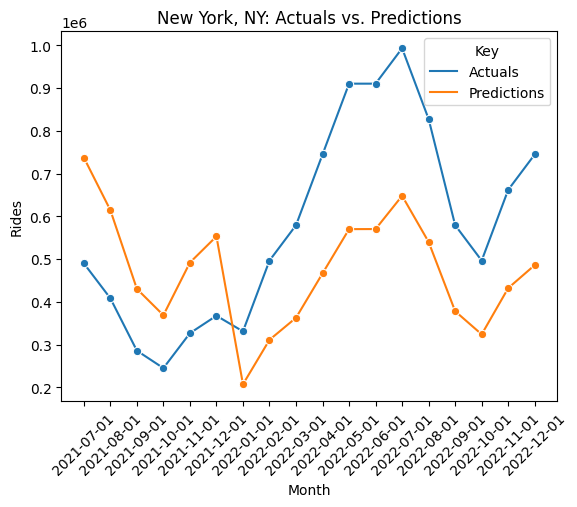

In [82]:
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
stn_filtered_data = plot_df[plot_df['station_name']=="New York, NY"]
name = stn_filtered_data['station_name'].unique()[0]

                            
sns.lineplot(data=stn_filtered_data, x='year_month', y='Rides', hue='key', marker='o')

#Show the plot
plt.title(f'{name}: Actuals vs. Predictions')
plt.xlabel('Month')
plt.ylabel('Rides')
plt.legend(title='Key')
plt.xticks(rotation=45) 

plt.show()


### Let's look at aggregated forecasts for routes and business lines

In [83]:
lines_routes = amtrak_df[['station_name','business_line','parent_route']].drop_duplicates()
full_df = pd.merge(plot_df, lines_routes, on='station_name', how='left')
print('Dataset 1 Dimensions: ', plot_df.shape)
print('Dataset 2 Dimensions: ', lines_routes.shape)
print('Final Dataset Dimensions: ', full_df.shape)

Dataset 1 Dimensions:  (14328, 4)
Dataset 2 Dimensions:  (398, 3)
Final Dataset Dimensions:  (14328, 6)


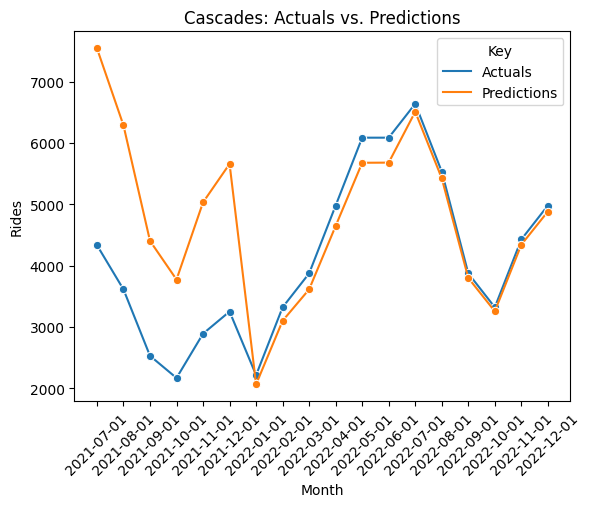

In [52]:
#----- Take a look at the predictions for parent routes
route_data = full_df[full_df['parent_route']=="Cascades"]
name = route_data['parent_route'].unique()[0]

route_data = pd.DataFrame(route_data.groupby(['year_month','key'])['Rides'].sum()).reset_index()

sns.lineplot(data=route_data, x='year_month', y='Rides', hue='key', marker='o')
#Show the plot
plt.title(f'{name}: Actuals vs. Predictions')
plt.xlabel('Month')
plt.ylabel('Rides')
plt.legend(title='Key')
plt.xticks(rotation=45) 

plt.show()

In [53]:
full_df['business_line'].unique()

array(['Northeast Corridor', 'Long Distance', 'State Supported', 'Other'],
      dtype=object)

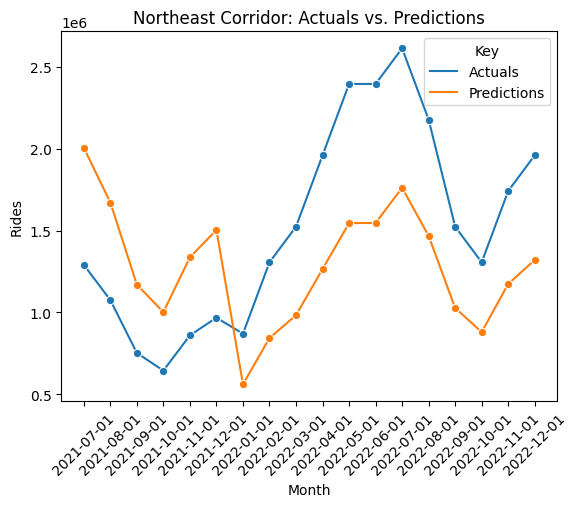

In [85]:
#----- Plot predictions for business lines

bus_line_data = full_df[full_df['business_line']=="Northeast Corridor"]
name = bus_line_data['business_line'].unique()[0]

bus_line_data = pd.DataFrame(bus_line_data.groupby(['year_month','key'])['Rides'].sum()).reset_index()

sns.lineplot(data=bus_line_data, x='year_month', y='Rides', hue='key', marker='o')

#Show the plot
plt.title(f'{name}: Actuals vs. Predictions')
plt.xlabel('Month')
plt.ylabel('Rides')
plt.legend(title='Key')
plt.xticks(rotation=45) 

plt.show()

### Step 3b: Diagnostics

In [86]:
# Convert the list of dictionaries to a DataFrame
diagnostic_stats_df = pd.DataFrame(diagnostic_stats)

# Display the diagnostic statistics table
diagnostic_stats_df.head(3)

,station_name,mean_deviance_residuals,std_deviance_residuals,mean_pearson_residuals,std_pearson_residuals,mean_leverage,std_leverage,mean_cooks_distance,std_cooks_distance
0,"Aberdeen, MD",-0.443990,10.714877,-0.049453,10.793308,0.19697,0.042620,2.430887,2.131790
1,"Albany, NY",-1.174084,37.609499,-0.143099,38.037017,0.19697,0.041351,29.665784,28.281301
2,"Albany, OR",-0.246745,7.637536,-0.033851,7.701079,0.19697,0.042170,1.245146,1.300287


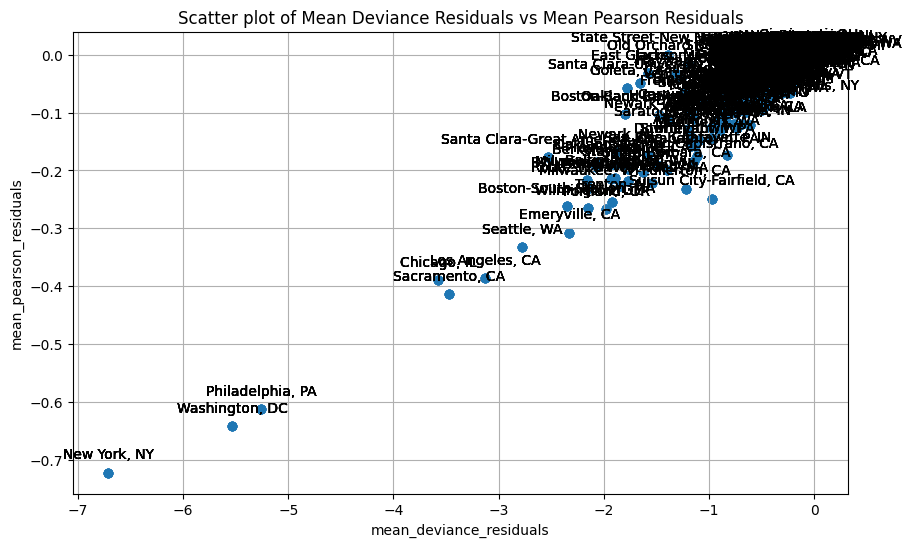

In [87]:
# Scatter plot
x_col = 'mean_deviance_residuals'
y_col = 'mean_pearson_residuals'

x_proper = x_col.replace('_', ' ').title().replace(' ', ' ')
y_proper = y_col.replace('_', ' ').title().replace(' ', ' ')

plt.figure(figsize=(10, 6))
plt.scatter(diagnostic_stats_df[x_col], diagnostic_stats_df[y_col])

# Add labels to each point
for i, row in diagnostic_stats_df.iterrows():
    plt.annotate(row['station_name'], (row[x_col], row[y_col]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f'Scatter plot of {x_proper} vs {y_proper}')
plt.grid(True)
plt.show()

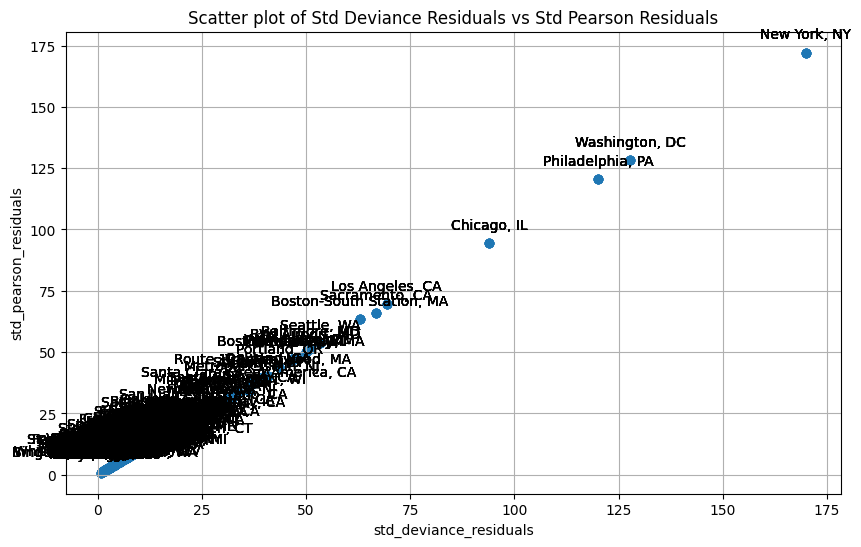

In [88]:
# Scatter plot
x_col = 'std_deviance_residuals'
y_col = 'std_pearson_residuals'

x_proper = x_col.replace('_', ' ').title().replace(' ', ' ')
y_proper = y_col.replace('_', ' ').title().replace(' ', ' ')


plt.figure(figsize=(10, 6))
plt.scatter(diagnostic_stats_df[x_col], diagnostic_stats_df[y_col])

# Add labels to each point
for i, row in diagnostic_stats_df.iterrows():
    plt.annotate(row['station_name'], (row[x_col], row[y_col]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f'Scatter plot of {x_proper} vs {y_proper}')
plt.grid(True)
plt.show()

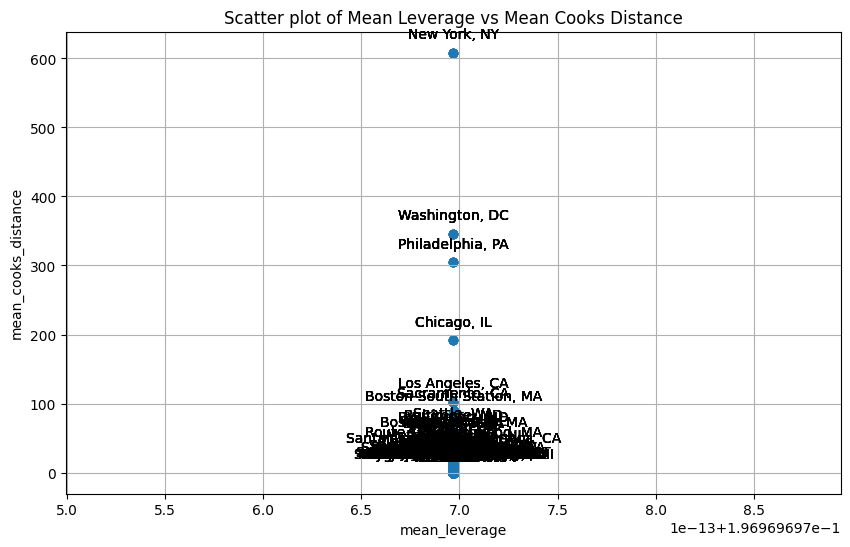

In [89]:
# Scatter plot
x_col = 'mean_leverage'
y_col = 'mean_cooks_distance'

x_proper = x_col.replace('_', ' ').title().replace(' ', ' ')
y_proper = y_col.replace('_', ' ').title().replace(' ', ' ')


plt.figure(figsize=(10, 6))
plt.scatter(diagnostic_stats_df[x_col], diagnostic_stats_df[y_col])

# Add labels to each point
for i, row in diagnostic_stats_df.iterrows():
    plt.annotate(row['station_name'], (row[x_col], row[y_col]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f'Scatter plot of {x_proper} vs {y_proper}')
plt.grid(True)
plt.show()

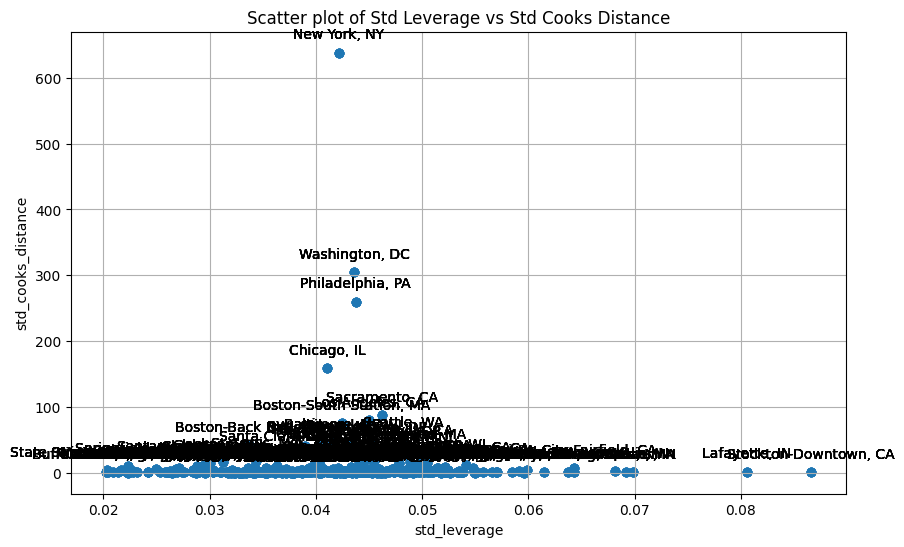

In [90]:
# Scatter plot
x_col = 'std_leverage'
y_col = 'std_cooks_distance'

x_proper = x_col.replace('_', ' ').title().replace(' ', ' ')
y_proper = y_col.replace('_', ' ').title().replace(' ', ' ')


plt.figure(figsize=(10, 6))
plt.scatter(diagnostic_stats_df[x_col], diagnostic_stats_df[y_col])

# Add labels to each point
for i, row in diagnostic_stats_df.iterrows():
    plt.annotate(row['station_name'], (row[x_col], row[y_col]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f'Scatter plot of {x_proper} vs {y_proper}')
plt.grid(True)
plt.show()

### Step 4: Run model on calibration set

In [102]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

%time

# Ensure 'year_month' is in datetime format
calib_df['year_month'] = pd.to_datetime(calib_df['year_month'])

# Convert dates to numeric format
calib_df['date_num'] = (calib_df['year_month'] - calib_df['year_month'].min()).dt.days


# Add seasonal component (e.g., month of the year)
calib_df['month'] = calib_df['year_month'].dt.month

# Predict with each model
calib_data_predictions = {}

# Predict with each model and calculate diagnostics
diagnostic_stats_new = []

# Iterate through the stations in the new dataset
for station in calib_df['station_name'].unique():
    if station in models:
        model = models[station]

        # Filter new data for the current station
        station_data = calib_df[calib_df['station_name'] == station]

        # Make predictions
        station_data['predicted_rides'] = model.predict(station_data)
        
        # Store predictions
        calib_data_predictions[station] = station_data

        # Calculate diagnostic statistics
        y_true = station_data['Rides']
        y_pred = station_data['predicted_rides']

        # Deviance residuals
        deviance_residuals = np.sign(y_true - y_pred) * np.sqrt(2 * (y_true * np.log(y_true / y_pred) - (y_true - y_pred)))
        pearson_residuals = (y_true - y_pred) / np.sqrt(y_pred)

        influence = model.get_influence()
        leverage = influence.hat_matrix_diag
        cooks_distance = influence.cooks_distance[0]

        # Store diagnostic statistics
        diagnostics = {
            'station_name': station,
            'mean_deviance_residuals': np.mean(deviance_residuals),
            'std_deviance_residuals': np.std(deviance_residuals),
            'mean_pearson_residuals': np.mean(pearson_residuals),
            'std_pearson_residuals': np.std(pearson_residuals),
            'mean_leverage': np.mean(leverage),
            'std_leverage': np.std(leverage),
            'mean_cooks_distance': np.mean(cooks_distance),
            'std_cooks_distance': np.std(cooks_distance)
        }
        diagnostic_stats_new.append(diagnostics)

        
    else:
        print(f"No model found for {station}")

print("Predictions done.")


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs
Predictions done.


### Step 4a: Plot some predictions


In [119]:
# # Create a list of DataFrames with added station names
# dfs_with_station_names = []
# for station_name, df in calib_data_predictions.items():
#     df_with_station_name = df.copy()
#     df_with_station_name['station_name'] = station_name
#     dfs_with_station_names.append(df_with_station_name)

# # Stack the DataFrames into a single DataFrame
# calib_preds_df = pd.concat(dfs_with_station_names, ignore_index=True)
# calib_preds_df.head(2)

,Year,Month,Rides,address,state,station_name,abbrev,lat,lon,num_routes,active_routes,active_rides,parent_route,business_line,year_month,weight,date_num,month,predicted_rides
0,2021,7,1701.6,"18 E Bel Air Ave Aberdeen, MD 21001-3701",MD,"Aberdeen, MD",ABE,39.509437,-76.163827,1,['northeast_regional_route'],[21767995.0],Northeast Regional,Northeast Corridor,2021-07-01,1,0,7,5596.350310
1,2021,8,1418.0,"18 E Bel Air Ave Aberdeen, MD 21001-3701",MD,"Aberdeen, MD",ABE,39.509437,-76.163827,1,['northeast_regional_route'],[21767995.0],Northeast Regional,Northeast Corridor,2021-08-01,1,31,8,4663.625259


### Step 4b: Diagnostics

### Step 5: Refit model with all data